# HelpTheBlind





### Drive Setup

In [1]:
from google.colab import drive 
ROOT = "/content/drive"    
print(ROOT)                
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
#@title Default title text
%cd '/content/drive/'
%ls

/content/drive
MyDrive/


In [3]:
# %ls Shareddrives/

In [4]:
%cd '/content/drive/MyDrive/HelpTheBlind'
%ls 

/content/drive/MyDrive/HelpTheBlind
 CaptionTest.ipynb    Flickr_TextData/      model.png
 CaptionTrain.ipynb   glove.6B.50d.txt      model_weights/
 car.jpeg             glove6b50dtxt.zip     model_weights.h5
 Computed/            ImageId2Caption.txt   scene.jpg
 dining.jpeg          Images/               test1.jpeg
 flickr8k.zip         kaggle.json           train_encoded_images.p
 flickr_data/         model_plot.png       'Untitled site.gsite'


### Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import 
from tensorflow.keras.utils import to_categorical

from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add,Concatenate

import pprint
pp = pprint.PrettyPrinter(indent=3).pprint


## Data Download

In [6]:
# !ls -lha kaggle.json

In [7]:
# !pip install -q kaggle

In [8]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [9]:
# !chmod 600 /root/.kaggle/kaggle.json

In [10]:
# !kaggle datasets download -d watts2/glove6b50dtxt

In [11]:
!pwd

/content/drive/MyDrive/HelpTheBlind


In [12]:
# !kaggle datasets download -d shadabhussain/flickr8k

In [13]:
# !unzip flickr8k

In [14]:
# !unzip glove6b50dtxt.zip

In [15]:
!pwd

/content/drive/MyDrive/HelpTheBlind


In [16]:
!ls

 CaptionTest.ipynb    Flickr_TextData	    model.png
 CaptionTrain.ipynb   glove.6B.50d.txt	    model_weights
 car.jpeg	      glove6b50dtxt.zip     model_weights.h5
 Computed	      ImageId2Caption.txt   scene.jpg
 dining.jpeg	      Images		    test1.jpeg
 flickr8k.zip	      kaggle.json	    train_encoded_images.p
 flickr_data	      model_plot.png	   'Untitled site.gsite'


# Img id to Caption Maping

In [17]:
with open("Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [18]:
captions=captions.split("\n")
len(captions)

40461

In [19]:
pp(captions[0:5])
pp(captions[-5:])

[  '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set '
   'of stairs in an entry way .',
   '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
   '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden '
   'playhouse .',
   '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her '
   'playhouse .',
   '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a '
   'wooden cabin .']
[  '997722733_0cb5439472.jpg#1\tA man is rock climbing high in the air .',
   '997722733_0cb5439472.jpg#2\tA person in a red shirt climbing up a rock '
   'face covered in assist handles .',
   '997722733_0cb5439472.jpg#3\tA rock climber in a red shirt .',
   '997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing '
   'wall .',
   '']


In [20]:
captions[2]

'1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .'

In [21]:
captions=captions[:-1]

In [22]:
pp(captions[0:2])
pp(captions[-2:])

[  '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set '
   'of stairs in an entry way .',
   '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .']
[  '997722733_0cb5439472.jpg#3\tA rock climber in a red shirt .',
   '997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing '
   'wall .']


In [23]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [24]:
len(captions)

40460

In [25]:
allwords=[]

In [26]:
def cleantext(text="A rock climber practices on a rock climbing wall ."):

  text= text.lower()

  #remove puntuations

  text = re.sub("[^a-z]+"," ",text)

  words = text.split()
   
  text = " ".join([word for word in words if len(word)>1])

  allwords.extend(list(text.split()))

  return text


In [27]:
# img,description = captions[0].split('.jpg')
# description=cleantext(description)
# img,description

In [28]:
ImageIdToCaption = {}

for caption in captions:
  try :
    img,description= caption.split(".jpg")
    
    if(ImageIdToCaption.get(img)== None):
      ImageIdToCaption[img]= []

    ImageIdToCaption[img].append(cleantext(description))

  except:
      print(caption)

In [29]:
ImageIdToCaption["997722733_0cb5439472"]

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [30]:
with open("Computed/ImageId2Caption.txt","w") as f:
  f.write( str(ImageIdToCaption) )

In [31]:
# cleantext()

# Vocabulary

In [32]:
ImageIdToCaption=None
with open("Computed/ImageId2Caption.txt","r") as f:
  ImageIdToCaption=f.read()
  ImageIdToCaption = json.loads(ImageIdToCaption.replace("'", "\""))

In [33]:
import collections

counter= collections.Counter(allwords)
orignalVocab = dict(counter)

In [34]:
orignalVocabSize=len(orignalVocab)
orignalVocabSize

8424

In [35]:
newVocab = sorted(orignalVocab.items(), reverse=True, key = lambda x: x[1])
newVocab = [x for x in newVocab if x[1]>10]
all_vocab = [x[0] for x in newVocab]

In [36]:
newVocabSize=len(newVocab)
newVocabSize

1845

In [37]:
newVocab[-5:-1],len(newVocab)

([('drag', 11), ('motor', 11), ('seagulls', 11), ('bridesmaids', 11)], 1845)

# Train Test

In [38]:
newVocab[:5]

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863)]

In [39]:
with open("Flickr_TextData/Flickr_8k.trainImages.txt","r") as f:
  train=f.read()
  train= train.split('\n')[:-1]

In [40]:
train[0:3],train[-2:]

(['2513260012_03d33305cf.jpg',
  '2903617548_d3e38d7f88.jpg',
  '3338291921_fe7ae0c8f8.jpg'],
 ['3107889179_106d223345.jpg', '2671602981_4edde92658.jpg'])

In [41]:
with open("Flickr_TextData/Flickr_8k.testImages.txt","r") as f:
  test=f.read()
  test= test.split('\n')[:-1]

In [42]:
test[0:3],test[-2:]

(['3385593926_d3e9c21170.jpg',
  '2677656448_6b7e7702af.jpg',
  '311146855_0b65fdb169.jpg'],
 ['2623930900_b9df917b82.jpg', '3490736665_38710f4b91.jpg'])

In [43]:
train_imgid2captions = {}

for t in train:
    x,_=t.split('.jpg')
    train_imgid2captions[x] = []
    for cap in ImageIdToCaption[x]:
        cap_to_append = "startseq " + cap + " endseq"
        train_imgid2captions[x].append(cap_to_append)

In [44]:
pp(train_imgid2captions['2513260012_03d33305cf'])

[  'startseq black dog is running after white dog in the snow endseq',
   'startseq black dog chasing brown dog through snow endseq',
   'startseq two dogs chase each other across the snowy ground endseq',
   'startseq two dogs play together in the snow endseq',
   'startseq two dogs running through low lying body of water endseq']


#  Image Feature Extraction

In [45]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102973440/102967424 [==============================] - 1s 0us/step


In [46]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [47]:
featureExtractorModel = Model(model.input, model.layers[-2].output)

In [48]:
# from keras.utils.vis_utils import plot_model
# plot_model(featureExtractorModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [50]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = featureExtractorModel.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [51]:
# start = time()
from keras.utils.vis_utils import plot_model
# plot_model(featureExtractorModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# encoding_train = {}

# for ix, img in enumerate(train):
    
#     imgpath = "./Images/{}".format(img)
#     encoding_train[img] = encode_image(imgpath)
    
#     if ix%100==0:
#         print(" [ Encoding image ] "+ str(ix))

# end= time()
# print("Time taken in seconds =", end-start)

In [52]:
# with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

In [53]:
with open("./Computed/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [54]:
# start = time()

# encoding_test = {}

# for ix, img in enumerate(test):
    
#     Testpath = "./Images/{}".format(img)
#     encoding_test[img] = encode_image(Testpath)
    
#     if ix%100==0:
#         print(" [ Encoding Test Image ] "+ str(ix))

# end= time()
# print("Time taken in seconds =", end-start)

In [55]:
# with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [56]:
with open("./Computed/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

#Preprocess Captions

In [57]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""

ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [58]:
ix

1846

In [59]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [60]:
with open("./Computed/Word2SeqNumbers.pkl", "wb") as encoded_pickle:
    pickle.dump([word_to_idx,idx_to_word], encoded_pickle)

In [61]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [62]:
all_captions_len = []

for key in train_imgid2captions.keys():
    for cap in train_imgid2captions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [63]:
pp(len(to_categorical([2], num_classes=vocab_size)[0]))

1848


In [64]:
import tensorflow as tf

# Creating Data Generator

In [65]:
def data_generator(train_imgid2captions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_imgid2captions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                #word to seq Numbers
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y) 
                X1, X2, y = [], [], []
                n=0

In [66]:
# x=data_generator(train_imgid2captions, encoding_train, word_to_idx, max_len, 50)

In [67]:
# y=next(x)

In [68]:
# len(y)

In [69]:
# y[0][0].shape,y[0][1].shape

In [70]:
# y[1].shape

In [71]:
!ls

 CaptionTest.ipynb    Flickr_TextData	    model.png
 CaptionTrain.ipynb   glove.6B.50d.txt	    model_weights
 car.jpeg	      glove6b50dtxt.zip     model_weights.h5
 Computed	      ImageId2Caption.txt   scene.jpg
 dining.jpeg	      Images		    test1.jpeg
 flickr8k.zip	      kaggle.json	    train_encoded_images.p
 flickr_data	      model_plot.png	   'Untitled site.gsite'


In [72]:
with open("./glove.6B.50d.txt",encoding='utf8') as f:
  embedding_index = {}
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype="float")
      
      embedding_index[word] = coefs



In [73]:
emb_dim = 50
embedding_output = np.zeros((vocab_size,emb_dim))

for word, idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        embedding_output[idx] = embedding_vector
            

# Model

In [74]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [75]:
# Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)([0])

In [76]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [77]:
decoder1 = add([inp_img2 , inp_cap3 ])
# decoder1 = Concatenate()([inp_img2 , inp_cap3 ])

In [78]:

decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea,input_cap], outputs=outputs)

In [79]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [80]:

# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [81]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

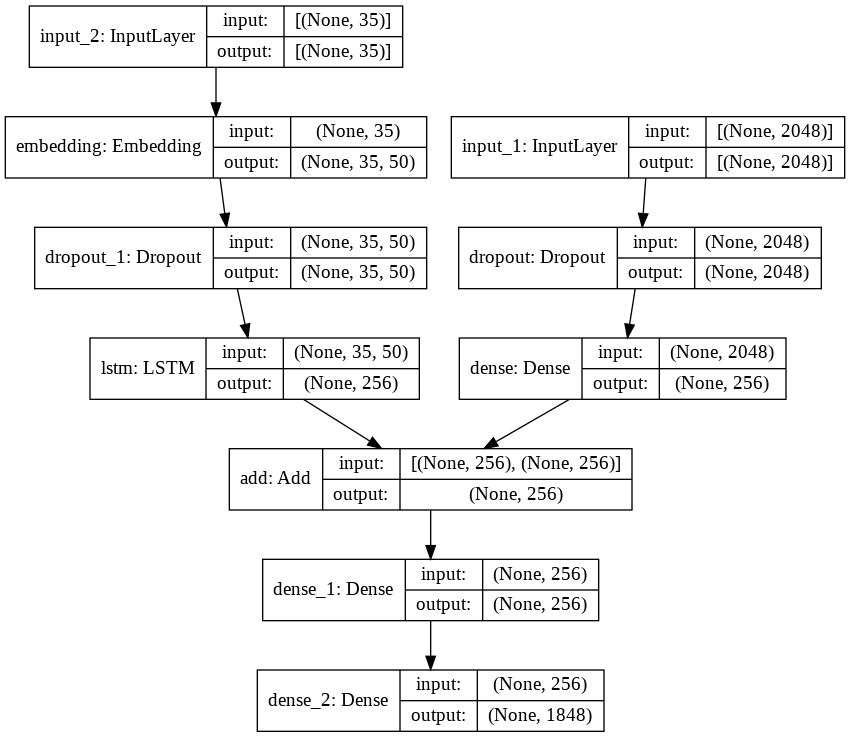

In [82]:
	plot_model(model, to_file='model.png', show_shapes=True)

In [83]:

epochs = 20
batch_size = 3
number_pics_per_batch = 3
steps = len(train_imgid2captions)//number_pics_per_batch

In [84]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [85]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [86]:
for i in range(epochs):
    generatorx = data_generator(train_imgid2captions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator=generatorx, epochs=1, steps_per_epoch=steps, verbose=1)
    # x=next(generator)
    # x[0][0]=tf.convert_to_tensor(x[0][0])
    # x[0][1]=tf.convert_to_tensor(x[0][1])
    # x[1]=tf.convert_to_tensor(x[1])                    
    # pp(len(x))
    # model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 31s 15ms/step - loss: 2.5660


In [100]:
model.save("model_weights/ResnetGlove/1")
# model.save('./model_weights/model' + str(i) + '.h5')

INFO:tensorflow:Assets written to: model_weights/ResnetGlove/1/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: model_weights/ResnetGlove/1/assets


# Prediction

In [88]:
model = load_model("./model_weights/model19.h5")

In [89]:
!ls

 CaptionTest.ipynb    Flickr_TextData	    model.png
 CaptionTrain.ipynb   glove.6B.50d.txt	    model_weights
 car.jpeg	      glove6b50dtxt.zip     model_weights.h5
 Computed	      ImageId2Caption.txt   scene.jpg
 dining.jpeg	      Images		    test1.jpeg
 flickr8k.zip	      kaggle.json	    train_encoded_images.p
 flickr_data	      model_plot.png	   'Untitled site.gsite'


In [90]:
def preprocess_image(img):
  img = image.load_img(img, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img
def encode_image(img):
  img = preprocess_image(img)
  feature_vector = featureExtractorModel.predict(img)
  feature_vector = feature_vector.reshape(feature_vector.shape[1],)
  return feature_vector

In [91]:
with open("./Computed/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [92]:
with open("./Computed/Word2SeqNumbers.pkl", "rb") as Word2SeqNumbers:
    word_to_idx,idx_to_word=pickle.load( Word2SeqNumbers)

In [93]:
max_len=35

In [94]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
      
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [96]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread("./Images/"+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)

Output hidden; open in https://colab.research.google.com to view.